<a href="https://colab.research.google.com/github/nitinranjansharma/EVA5B2/blob/main/s5/EVA4S5F9_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

### Target: Reach 99.4% accuracy on validation using 10k params in 15 epochs
### 1. Process - Used Conv relu Conv block to forumalte the model
### 2. Results - Params - 8546
### 3. Best Train accuracy - 99.34
###    Best Test accuracy - 99.41
### 4. Analysis
###   a. The model has lesser number of params
###   b. Dropping dropouts, and using resnet architecture
###   c. Model stable after 10th Epoch


In [ ]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise. 


In [ ]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                       transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.RandomRotation((-9.0, 9.0), fill=(1,)),
                                       #transforms.CenterCrop(24),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      # transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [ ]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

# Dataloader Arguments & Test/Train Dataloaders


In [ ]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


# The model
Let's start with the model we first saw

In [ ]:
import torch.nn.functional as F
dropout_value = 0.1
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(10),
            #nn.Dropout(dropout_value)
        ) # output_size = 26 ,Reseptive Field 3

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            #nn.Dropout(dropout_value)
        ) # output_size = 24 ,Reseptive Field 5

        # TRANSITION BLOCK 1

        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 12 ,Reseptive Field 6

        ## RES block 1
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU(),
            #nn.Dropout(dropout_value)
        ) # output_size = 12 ,Reseptive Field 6

        # CONVOLUTION BLOCK 2
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(10),
            #nn.Dropout(dropout_value)
        ) # output_size = 10,Reseptive Field 10

        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=32, kernel_size=(1, 1), padding=0, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            #nn.Dropout(dropout_value)
        ) # output_size = 10, ,Reseptive Field 10

        #RES Block 2
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(10),
            #nn.Dropout(dropout_value)
        ) # output_size = 10 ,Reseptive Field 10

        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(10),
            #nn.Dropout(dropout_value)
        ) # output_size = 8,Reseptive Field 14

        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=32, kernel_size=(1, 1), padding=0, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            #nn.Dropout(dropout_value)
        ) # output_size = 8 ,Reseptive Field 14

        #RES Block 3
        self.convblock9 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(10),
            #nn.Dropout(dropout_value)
        ) # output_size = 8,Reseptive Field 14

        self.convblock10 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=14, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(14),
            #nn.Dropout(dropout_value)
        ) # output_size = 6,Reseptive Field 18

        self.convblock11 = nn.Sequential(
            nn.Conv2d(in_channels=14, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(16),
            #nn.Dropout(dropout_value)
        ) # output_size = 4,Reseptive Field 22
        
        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=4)
        ) # output_size = 1, Reseptive Field 28

        self.convblock12 = nn.Sequential(
              nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            # nn.BatchNorm2d(10),
            # nn.ReLU(),
            # nn.Dropout(dropout_value)
        ) # output_size = 1, Reseptive Field 28


        self.dropout = nn.Dropout(dropout_value)

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        #x = self.pool2(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.convblock8(x)
        x = self.convblock9(x)
        x = self.convblock10(x)
        x = self.convblock11(x)
        x = self.gap(x)        
        x = self.convblock12(x)

        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)




Code shared #param: 8546

# Model Params
Can't emphasize on how important viewing Model Summary is. 
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [ ]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 26, 26]              90
              ReLU-2           [-1, 10, 26, 26]               0
       BatchNorm2d-3           [-1, 10, 26, 26]              20
            Conv2d-4           [-1, 16, 24, 24]           1,440
              ReLU-5           [-1, 16, 24, 24]               0
       BatchNorm2d-6           [-1, 16, 24, 24]              32
            Conv2d-7           [-1, 10, 24, 24]             160
       BatchNorm2d-8           [-1, 10, 24, 24]              20
              ReLU-9           [-1, 10, 24, 24]               0
        MaxPool2d-10           [-1, 10, 12, 12]               0
           Conv2d-11           [-1, 10, 10, 10]             900
             ReLU-12           [-1, 10, 10, 10]               0
      BatchNorm2d-13           [-1, 10, 10, 10]              20
           Conv2d-14           [-1

# Training and Testing

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs. 

Let's write train and test functions

In [ ]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))
    #return test_loss

In [ ]:
#for model with two resnet block 
from torch.optim.lr_scheduler import StepLR

model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size=6, gamma=0.5)

EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    scheduler.step()
    print('current Learing Rate: ', optimizer.state_dict()["param_groups"][0]["lr"])
    #val_loss = 
    test(model, device, test_loader)



  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0


Loss=0.11214590072631836 Batch_id=468 Accuracy=88.32: 100%|██████████| 469/469 [00:43<00:00, 10.90it/s]


current Learing Rate:  0.01


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0665, Accuracy: 9835/10000 (98.35%)

EPOCH: 1


Loss=0.09433918446302414 Batch_id=468 Accuracy=97.74: 100%|██████████| 469/469 [00:42<00:00, 10.91it/s]

current Learing Rate:  0.01



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0595, Accuracy: 9829/10000 (98.29%)

EPOCH: 2


Loss=0.05425375699996948 Batch_id=468 Accuracy=98.27: 100%|██████████| 469/469 [00:43<00:00, 10.85it/s]

current Learing Rate:  0.01



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0402, Accuracy: 9877/10000 (98.77%)

EPOCH: 3


Loss=0.011051923967897892 Batch_id=468 Accuracy=98.46: 100%|██████████| 469/469 [00:42<00:00, 11.03it/s]

current Learing Rate:  0.01



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0519, Accuracy: 9841/10000 (98.41%)

EPOCH: 4


Loss=0.00902416929602623 Batch_id=468 Accuracy=98.64: 100%|██████████| 469/469 [00:43<00:00, 10.85it/s]

current Learing Rate:  0.01



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0290, Accuracy: 9920/10000 (99.20%)

EPOCH: 5


Loss=0.02549041621387005 Batch_id=468 Accuracy=98.83: 100%|██████████| 469/469 [00:42<00:00, 11.04it/s]

current Learing Rate:  0.005



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0303, Accuracy: 9896/10000 (98.96%)

EPOCH: 6


Loss=0.03081030212342739 Batch_id=468 Accuracy=98.99: 100%|██████████| 469/469 [00:42<00:00, 10.98it/s]

current Learing Rate:  0.005



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0238, Accuracy: 9926/10000 (99.26%)

EPOCH: 7


Loss=0.08570990711450577 Batch_id=468 Accuracy=99.01: 100%|██████████| 469/469 [00:43<00:00, 10.82it/s]

current Learing Rate:  0.005



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0212, Accuracy: 9937/10000 (99.37%)

EPOCH: 8


Loss=0.008049164898693562 Batch_id=468 Accuracy=99.09: 100%|██████████| 469/469 [00:42<00:00, 10.91it/s]

current Learing Rate:  0.005



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0248, Accuracy: 9924/10000 (99.24%)

EPOCH: 9


Loss=0.05069735646247864 Batch_id=468 Accuracy=99.06: 100%|██████████| 469/469 [00:42<00:00, 10.98it/s]

current Learing Rate:  0.005



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0218, Accuracy: 9939/10000 (99.39%)

EPOCH: 10


Loss=0.04626016691327095 Batch_id=468 Accuracy=99.11: 100%|██████████| 469/469 [00:43<00:00, 10.90it/s]

current Learing Rate:  0.005



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0221, Accuracy: 9935/10000 (99.35%)

EPOCH: 11


Loss=0.017562782391905785 Batch_id=468 Accuracy=99.21: 100%|██████████| 469/469 [00:43<00:00, 10.88it/s]

current Learing Rate:  0.0025



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0202, Accuracy: 9940/10000 (99.40%)

EPOCH: 12


Loss=0.00921888928860426 Batch_id=468 Accuracy=99.25: 100%|██████████| 469/469 [00:42<00:00, 11.04it/s]

current Learing Rate:  0.0025



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0191, Accuracy: 9941/10000 (99.41%)

EPOCH: 13


Loss=0.06074872240424156 Batch_id=468 Accuracy=99.34: 100%|██████████| 469/469 [00:43<00:00, 10.88it/s]

current Learing Rate:  0.0025



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0199, Accuracy: 9937/10000 (99.37%)

EPOCH: 14


Loss=0.025518519803881645 Batch_id=468 Accuracy=99.31: 100%|██████████| 469/469 [00:43<00:00, 10.73it/s]

current Learing Rate:  0.0025



Test set: Average loss: 0.0182, Accuracy: 9940/10000 (99.40%)



Text(0.5, 1.0, 'Test Accuracy')

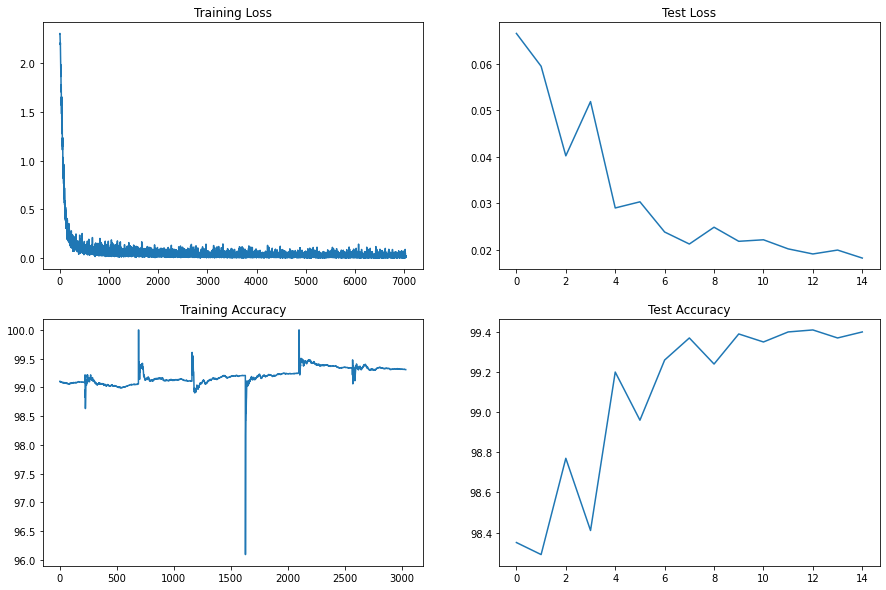

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc[4000:])
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")